## Var init

In [1]:
filename = "train"

In [2]:
FN0 = 'vocabulary-embedding'

In [3]:
FN1 = 'train'

In [4]:
maxlend=25 # 0 - if we dont want to use description at all
maxlenh=25
maxlen = maxlend + maxlenh
rnn_size = 512 # must be same as 160330-word-gen
rnn_layers = 3  # match FN1
batch_norm=False

In [5]:
activation_rnn_size = 40 if maxlend else 0

In [6]:
# training parameters
seed=42
p_W, p_U, p_dense, weight_decay = 0, 0, 0, 0
optimizer = 'adam'
LR = 1e-4
batch_size=64
nflips=10

In [7]:
nb_train_samples = 30000 # orig was 30k
nb_val_samples = 3000 # orig was 3k

In [8]:
nb_unknown_words = 10

## Rebuild the Model

### read word embedding

In [9]:
import pickle

with open('data/%s.pkl'%FN0, 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

In [10]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [11]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [12]:
oov0 = vocab_size-nb_unknown_words

In [13]:
for i in range(oov0, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [14]:
import numpy as np
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.utils import np_utils
import random, sys

### Model

In [15]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout, RepeatVector
from tensorflow.python.keras.layers.wrappers import TimeDistributed
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.regularizers import l2

In [16]:
# seed weight initialization
random.seed(seed)
np.random.seed(seed)

In [17]:
regularizer = l2(weight_decay) if weight_decay else None

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    input_length=maxlen,
                    embeddings_regularizer=regularizer, weights=[embedding], mask_zero=True,
                    name='embedding_1'))

for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                kernel_regularizer=regularizer, recurrent_regularizer=regularizer,
                bias_regularizer=regularizer, dropout=p_W, recurrent_dropout=p_U,
                name='lstm_%d'%(i+1)
                  )
    model.add(lstm)
    model.add(Dropout(p_dense,name='dropout_%d'%(i+1)))

In [19]:
from tensorflow.python.keras.layers.core import Lambda
import tensorflow.python.keras.backend as K

def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend,:], X[:,maxlend:,:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=(2,2))
    # make sure we dont use description words that are masked out
    activation_energies = activation_energies + -1e20*K.expand_dims(1.-K.cast(mask[:, :maxlend],'float32'),1)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=(2,1))
    return K.concatenate((desc_avg_word, head_words))

In [20]:
if activation_rnn_size:
    model.add(Lambda(simple_context,
                     mask = lambda inputs, mask: mask[:,maxlend:],
                     output_shape = lambda input_shape: (input_shape[0], maxlenh, 2*(rnn_size - activation_rnn_size)),
                     name='simplecontext_1'))
model.add(TimeDistributed(Dense(vocab_size,
                                kernel_regularizer=regularizer, bias_regularizer=regularizer,
                                name = 'timedistributed_1')))
model.add(Activation('softmax', name='activation_1'))

In [21]:
from tensorflow.python.keras.optimizers import Adam, RMSprop # usually I prefer Adam but article used rmsprop
# opt = Adam(lr=LR)  # keep calm and reduce learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [22]:
K.set_value(model.optimizer.lr,np.float32(LR))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           4000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 512)           1255424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 512)           2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 512)           0

## Sample generation

### Define required funs

In [24]:
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [25]:
# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty]*maxlend + [eos],
               k=1, maxsample=maxlen, use_unk=True, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [list(start)]
    live_scores = [0]

    while live_k:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk:
            for i in range(nb_unknown_words):
                cand_scores[:,vocab_size - 1 - i] = 1e20
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        ranks_dead = [r for r in ranks if r < n]
        ranks_live = [r - n for r in ranks if r >= n]
        
        dead_scores = [dead_scores[r] for r in ranks_dead]
        dead_samples = [dead_samples[r] for r in ranks_dead]
        
        live_scores = [live_scores[r] for r in ranks_live]

        # append the new words to their appropriate live sample
        voc_size = probs.shape[1]
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_live]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        zombie = [s[-1] == eos or len(s) > maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    return dead_samples + live_samples, dead_scores + live_scores

In [26]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = list(map(len, samples))
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([prob[sample_length-maxlend-1] for prob, sample_length in list(zip(probs, sample_lengths))])

In [27]:
def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < oov0 else glove_idx2idx.get(x,x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= oov0])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    return xs

In [28]:
def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= oov0:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [29]:
import sys
import Levenshtein

def gensamples(skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    result = {}
    i = random.randint(0,len(X_test)-1)
    result["HEAD"] = [idx2word[w] for w in Y_test[i][:maxlenh]]
    #print('HEAD:',' '.join(result["HEAD"][w] for w in range(len(result["HEAD"]))))
    result["DESC"] = [idx2word[w] for w in X_test[i][:maxlend]]
    #print('DESC:',' '.join(result["DESC"][w] for w in range(len(result["DESC"]))))
    sys.stdout.flush()
    
    print("Generating Headline...")
    #print('HEADS:')
    x = X_test[i]
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        #if short:
            #distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            #if distance > -0.6:
                #print(score, ' '.join(words))
                #print('%s (%.2f) %f'%(' '.join(words), score, distance))
        #else:
            #print(score, ' '.join(words))
        codes.append(code)

    result["HEADS"] = words
    result["CODES"] = codes
    return result

### Load test data

In [30]:
with open('data/%s.data.pkl'%FN0, 'rb') as fp:
    X, Y = pickle.load(fp)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=nb_val_samples, random_state=seed)
len(X_train), len(Y_train), len(X_test), len(Y_test)

(170028, 170028, 3000, 3000)

In [32]:
del X, Y
del X_train, Y_train

## BLEU-Score

### Generate examples per iteration

In [33]:
res = []
#batch_samples = nb_val_samples//batch_size
batch_samples = 3

for ite in range(3):
    res.append([])
    model.load_weights("data/train/01-it-{}.weights.hdf5".format(ite))
    for ex in range(1,batch_samples+1):
        print("{}. Iteration - {} of {} examples".format(ite,ex,batch_samples))
        res[ite].append(gensamples(skips=2, batch_size=batch_size, k=10, temperature=1.))
        print("="*30)

0. Iteration - 1 of 3 examples
Generating Headline...
0. Iteration - 2 of 3 examples
Generating Headline...
0. Iteration - 3 of 3 examples
Generating Headline...
1. Iteration - 1 of 3 examples
Generating Headline...
1. Iteration - 2 of 3 examples
Generating Headline...
1. Iteration - 3 of 3 examples
Generating Headline...
2. Iteration - 1 of 3 examples
Generating Headline...
2. Iteration - 2 of 3 examples
Generating Headline...
2. Iteration - 3 of 3 examples
Generating Headline...


### Compute 1-gramm Corpus-BLEU

In [34]:
from nltk.translate.bleu_score import corpus_bleu

score = []
score_weights = [1.]
for ite in range(len(res)):
    ref = []
    cand = []
    for ex in range(len(res[ite])):
        ref.append(res[ite][ex]["HEAD"])
        cand.append(res[ite][ex]["HEADS"])
    score.append(corpus_bleu(ref,cand,weights=score_weights))

### Plot BLEU-Score

In [35]:
import matplotlib.pyplot as plt

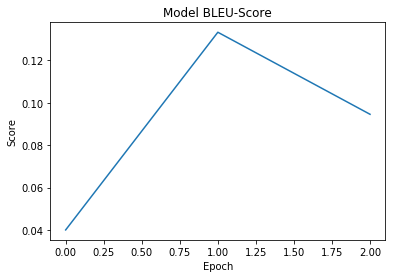

In [36]:
plt.plot(score)
plt.title('Model BLEU-Score')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.show()

## Loss

### Load the Training history

In [37]:
with open("data/train/01-it-2.history.pkl", "rb") as fp:
    history = pickle.load(fp)

### Plot the Log-Loss

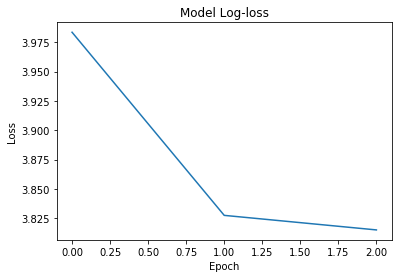

In [38]:
plt.plot(history['loss'])
plt.title('Model Log-loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()